## EY Data Challenge - Sentinel-2 Sample Notebook

This sample notebook can be used to create a Sentinel-2 satellite output product for a single date or a median mosaic for any time period. A median mosaic reflects the "median" value of pixels for all spectral bands in the time series. When scenes within a time series contain clouds, the use of a median calculation can statistically remove clouds from the final median mosaic product, assuming there are plenty of clear pixels within the time series. The output from this notebook is a GeoTIFF product suitable for further analysis and can also be used to generate spectral index products using mathematical combinations of bands, such as NDVI. The baseline data is [Sentinel-2 Level-2A](https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a) data from the MS Planetary Computer catalog.

In [ ]:
!pip install odc-stac

In [1]:
# Supress Warnings 
import warnings
warnings.filterwarnings('ignore')

# Import common GIS tools
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import rioxarray as rio
import rasterio
from matplotlib.cm import RdYlGn,jet,RdBu

# Import Planetary Computer tools
import stackstac
import pystac_client
import planetary_computer 
from odc.stac import stac_load

### Discover and load the data for analysis

First, we define our area of interest using latitude and longitude coordinates. 

In [2]:
# Define the bounding box for the entire data region using (Latitude, Longitude)
# This is the region of New York City that contains our temperature dataset
lower_left = (40.75, -74.01)
upper_right = (40.88, -73.86)

In [3]:
# Calculate the bounds for doing an archive data search
# bounds = (min_lon, min_lat, max_lon, max_lat)
bounds = (lower_left[1], lower_left[0], upper_right[1], upper_right[0])

In [4]:
# Define the time window
time_window = "2024-06-01/2024-09-01"

Using the `pystac_client` we can search the Planetary Computer's STAC endpoint for items matching our query parameters. We will use a period of 3 months as a representative dataset for the region. The query searches for "low cloud" scenes with overall cloud cover <30%. The result is the number of scenes matching our search criteria that touch our area of interest. Some of these may be partial scenes or contain clouds.

In [5]:
stac = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

search = stac.search(
    bbox=bounds, 
    datetime=time_window,
    collections=["sentinel-2-l2a"],
    query={"eo:cloud_cover": {"lt": 30}},
)

In [6]:
items = list(search.get_items())
print('This is the number of scenes that touch our region:',len(items))

This is the number of scenes that touch our region: 9


In [7]:
items

[<Item id=S2A_MSIL2A_20240827T154931_R054_T18TWL_20240827T221452>,
 <Item id=S2A_MSIL2A_20240824T153931_R011_T18TWL_20240824T221958>,
 <Item id=S2B_MSIL2A_20240822T154809_R054_T18TWL_20240822T215036>,
 <Item id=S2A_MSIL2A_20240814T153941_R011_T18TWL_20240814T223950>,
 <Item id=S2A_MSIL2A_20240715T153941_R011_T18TWL_20240716T000840>,
 <Item id=S2B_MSIL2A_20240703T154819_R054_T18TWL_20240705T191109>,
 <Item id=S2A_MSIL2A_20240628T154941_R054_T18TWL_20240629T040340>,
 <Item id=S2A_MSIL2A_20240618T154941_R054_T18TWL_20240618T232304>,
 <Item id=S2A_MSIL2A_20240615T153941_R011_T18TWL_20240616T005205>]

Next, we'll load the data into an [xarray](https://xarray.pydata.org/en/stable/) DataArray using [stackstac](https://stackstac.readthedocs.io/). We will only keep the commonly used spectral bands (Red, Green, Blue, NIR, SWIR). There are also several other <b>important settings for the data</b>: We have changed the projection to epsg=4326 which is standard latitude-longitude in degrees. We have specified the spatial resolution of each pixel to be 10-meters. 

In [8]:
signed_items = [planetary_computer.sign(item).to_dict() for item in items]

In [9]:
# Define the pixel resolution for the final product
# Define the scale according to our selected crs, so we will use degrees
resolution = 10  # meters per pixel 
scale = resolution / 111320.0 # degrees per pixel for crs=4326 

### Sentinel-2 Bands Summary 
The following list of common bands can be loaded by the Open Data Cube (ODC) stac command.<br><br>
B01 = Coastal Aerosol = 60m <br>
B02 = Blue = 10m <br>
B03 = Green = 10m <br>
B04 = Red = 10m <br>
B05 = Red Edge (704 nm) = 20m <br>
B06 = Red Edge (740 nm) = 20m <br>
B07 = Red Edge (780 nm) = 20m <br>
B08 = NIR (833 nm) = 10m <br>
B8A = NIR (narrow 864 nm) = 20m <br>
B11 = SWIR (1.6 um) = 20m <br>
B12 = SWIR (2.2 um) = 20m

In [10]:
data = stac_load(
    items,
    bands=["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12"],
    crs="EPSG:4326", # Latitude-Longitude
    resolution=scale, # Degrees
    chunks={"x": 2048, "y": 2048},
    dtype="uint16",
    patch_url=planetary_computer.sign,
    bbox=bounds
)

In [11]:
import geopandas as gpd
from shapely.geometry import Point

In [12]:
data

<xarray.Dataset> Size: 479MB
Dimensions:      (latitude: 1448, longitude: 1671, time: 9)
Coordinates:
  * latitude     (latitude) float64 12kB 40.88 40.88 40.88 ... 40.75 40.75 40.75
  * longitude    (longitude) float64 13kB -74.01 -74.01 -74.01 ... -73.86 -73.86
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 72B 2024-06-15T15:39:41.024000 ... 202...
Data variables:
    B01          (time, latitude, longitude) uint16 44MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B02          (time, latitude, longitude) uint16 44MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B03          (time, latitude, longitude) uint16 44MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B04          (time, latitude, longitude) uint16 44MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B05          (time, latitude, longitude) uint16 44MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B06          (time, latitude, longitude) uint16 44MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B07          (time, latitude, longitude) uint16 44MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B08          (time, latitude, longitude) uint16 44MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B8A          (time, latitude, longitude) uint16 44MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B11          (time, latitude, longitude) uint16 44MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B12          (time, latitude, longitude) uint16 44MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>

In [13]:
import pandas as pd 

ground_df=pd.read_csv('Training_data_uhi_index_2025-02-18.csv')
ground_df

Longitude   Latitude          datetime  UHI Index
0     -73.909167  40.813107  24-07-2021 15:53   1.030289
1     -73.909187  40.813045  24-07-2021 15:53   1.030289
2     -73.909215  40.812978  24-07-2021 15:53   1.023798
3     -73.909242  40.812908  24-07-2021 15:53   1.023798
4     -73.909257  40.812845  24-07-2021 15:53   1.021634
...          ...        ...               ...        ...
11224 -73.957050  40.790333  24-07-2021 15:57   0.972470
11225 -73.957063  40.790308  24-07-2021 15:57   0.972470
11226 -73.957093  40.790270  24-07-2021 15:57   0.981124
11227 -73.957112  40.790253  24-07-2021 15:59   0.981245
11228 -73.957128  40.790237  24-07-2021 15:59   0.983408

[11229 rows x 4 columns]

In [14]:
lat_values = data["latitude"].values
lon_values = data["longitude"].values

# Create a GeoDataFrame from the Xarray dataset
gdf = gpd.GeoDataFrame(
    geometry=[Point(lon, lat) for lon, lat in zip(lon_values, lat_values)],
    crs="EPSG:4326"
)

gdf

geometry
0     POINT (-74.01002 40.88003)
1     POINT (-74.00993 40.87994)
2     POINT (-74.00984 40.87985)
3     POINT (-74.00975 40.87976)
4     POINT (-74.00966 40.87967)
...                          ...
1443   POINT (-73.88039 40.7504)
1444   POINT (-73.8803 40.75031)
1445  POINT (-73.88021 40.75022)
1446  POINT (-73.88012 40.75013)
1447  POINT (-73.88003 40.75004)

[1448 rows x 1 columns]

In [15]:
# Convert CRS to projected (buffering works better in meters)
gdf = gdf.to_crs(epsg=26918)

# Create buffer zones of different sizes
gdf["buffer_50m"] = gdf.geometry.buffer(50)   # 100-meter buffer
gdf["buffer_100m"] = gdf.geometry.buffer(150)   # 500-meter buffer
gdf["buffer_150m"] = gdf.geometry.buffer(200) # 1 km buffer

# Convert back to lat/lon for mapping
gdf["buffer_50m"] = gdf.buffer_50m.to_crs(epsg=4326)
gdf["buffer_100m"] = gdf.buffer_100m.to_crs(epsg=4326)
gdf["buffer_150m"] =gdf.buffer_150m.to_crs(epsg=4326)

In [18]:
gdf

geometry  \
0     POINT (583410.542 4525911.097)   
1     POINT (583418.224 4525901.211)   
2     POINT (583425.905 4525891.324)   
3     POINT (583433.587 4525881.438)   
4     POINT (583441.269 4525871.551)   
...                              ...   
1443  POINT (594516.139 4511653.013)   
1444   POINT (594523.85 4511643.138)   
1445  POINT (594531.561 4511633.263)   
1446  POINT (594539.271 4511623.388)   
1447  POINT (594546.982 4511613.512)   

                                             buffer_50m  \
0     POLYGON ((-74.00942 40.88003, -74.00943 40.879...   
1     POLYGON ((-74.00933 40.87994, -74.00934 40.879...   
2     POLYGON ((-74.00924 40.87985, -74.00925 40.879...   
3     POLYGON ((-74.00915 40.87976, -74.00916 40.879...   
4     POLYGON ((-74.00906 40.87967, -74.00907 40.879...   
...                                                 ...   
1443  POLYGON ((-73.8798 40.7504, -73.8798 40.75035,...   
1444  POLYGON ((-73.87971 40.75031, -73.87971 40.750...   
1445  POLYGON ((-73.87962 40.75022, -73.87962 40.750...   
1446  POLYGON ((-73.87953 40.75013, -73.87953 40.750...   
1447  POLYGON ((-73.87944 40.75004, -73.87944 40.75,...   

                                            buffer_100m  \
0     POLYGON ((-74.00824 40.88002, -74.00825 40.879...   
1     POLYGON ((-74.00815 40.87993, -74.00816 40.879...   
2     POLYGON ((-74.00806 40.87984, -74.00807 40.879...   
3     POLYGON ((-74.00797 40.87975, -74.00798 40.879...   
4     POLYGON ((-74.00788 40.87966, -74.00789 40.879...   
...                                                 ...   
1443  POLYGON ((-73.87861 40.75039, -73.87862 40.750...   
1444  POLYGON ((-73.87852 40.7503, -73.87853 40.7501...   
1445  POLYGON ((-73.87843 40.75021, -73.87844 40.750...   
1446  POLYGON ((-73.87834 40.75012, -73.87835 40.749...   
1447  POLYGON ((-73.87825 40.75003, -73.87826 40.749...   

                                            buffer_150m  
0     POLYGON ((-74.00764 40.88001, -74.00766 40.879...  
1     POLYGON ((-74.00755 40.87992, -74.00757 40.879...  
2     POLYGON ((-74.00746 40.87983, -74.00748 40.879...  
3     POLYGON ((-74.00737 40.87974, -74.00739 40.879...  
4     POLYGON ((-74.00728 40.87965, -74.0073 40.8794...  
...                                                 ...  
1443  POLYGON ((-73.87802 40.75038, -73.87804 40.750...  
1444  POLYGON ((-73.87793 40.75029, -73.87795 40.750...  
1445  POLYGON ((-73.87784 40.7502, -73.87786 40.7500...  
1446  POLYGON ((-73.87775 40.75011, -73.87777 40.749...  
1447  POLYGON ((-73.87766 40.75002, -73.87768 40.749...  

[1448 rows x 4 columns]

In [19]:
from rasterstats import zonal_stats

path='S2_nomedian_update_sample.tiff'
# Get mean values of raster bands inside buffer zones
stats = zonal_stats(gdf, data, stats=["mean", "min", "max", "std", "median"])

stats_df = pd.DataFrame(stats)

stats_df

TypeError: invalid path or file: <xarray.Dataset> Size: 479MB
Dimensions:      (latitude: 1448, longitude: 1671, time: 9)
Coordinates:
  * latitude     (latitude) float64 12kB 40.88 40.88 40.88 ... 40.75 40.75 40.75
  * longitude    (longitude) float64 13kB -74.01 -74.01 -74.01 ... -73.86 -73.86
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 72B 2024-06-15T15:39:41.024000 ... 202...
Data variables:
    B01          (time, latitude, longitude) uint16 44MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B02          (time, latitude, longitude) uint16 44MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B03          (time, latitude, longitude) uint16 44MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B04          (time, latitude, longitude) uint16 44MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B05          (time, latitude, longitude) uint16 44MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B06          (time, latitude, longitude) uint16 44MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B07          (time, latitude, longitude) uint16 44MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B08          (time, latitude, longitude) uint16 44MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B8A          (time, latitude, longitude) uint16 44MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B11          (time, latitude, longitude) uint16 44MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B12          (time, latitude, longitude) uint16 44MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>

In [26]:
# View the dimensions of our XARRAY and the loaded variables
# This insures we have the right coordinates and spectral bands in our xarray
display(data)

<xarray.Dataset> Size: 479MB
Dimensions:      (latitude: 1448, longitude: 1671, time: 9)
Coordinates:
  * latitude     (latitude) float64 12kB 40.88 40.88 40.88 ... 40.75 40.75 40.75
  * longitude    (longitude) float64 13kB -74.01 -74.01 -74.01 ... -73.86 -73.86
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 72B 2024-06-15T15:39:41.024000 ... 202...
Data variables:
    B01          (time, latitude, longitude) uint16 44MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B02          (time, latitude, longitude) uint16 44MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B03          (time, latitude, longitude) uint16 44MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B04          (time, latitude, longitude) uint16 44MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B05          (time, latitude, longitude) uint16 44MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B06          (time, latitude, longitude) uint16 44MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B07          (time, latitude, longitude) uint16 44MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B08          (time, latitude, longitude) uint16 44MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B8A          (time, latitude, longitude) uint16 44MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B11          (time, latitude, longitude) uint16 44MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B12          (time, latitude, longitude) uint16 44MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>

### View RGB (real color) images from the time series
You will notice that some of the scenes have clouds. You may want to use a scene from a single date, or create a median mosaic using all of the data in the time series. Also, these images are merely for quick review and are not scaled correctly to reflect the proper Lat-Lon ratios. Finally, the numbering for these scenes starts at ZERO and goes from the top-left across the rows to reach the total number of scenes in the data array shown above. 

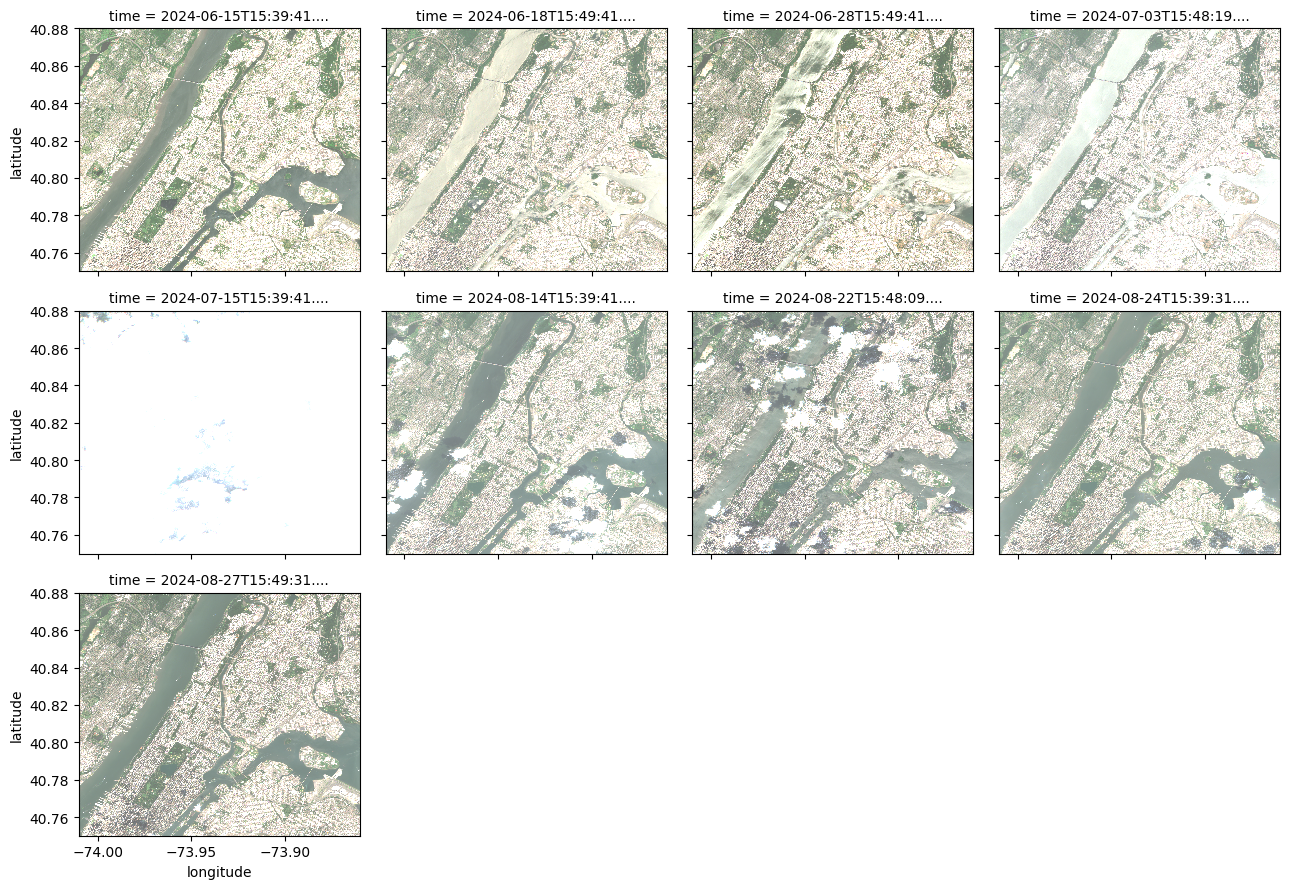

In [27]:
# Plot sample images from the time series
plot_data = data[["B04","B03","B02"]].to_array()
plot_data.plot.imshow(col='time', col_wrap=4, robust=True, vmin=0, vmax=2500)
plt.show()

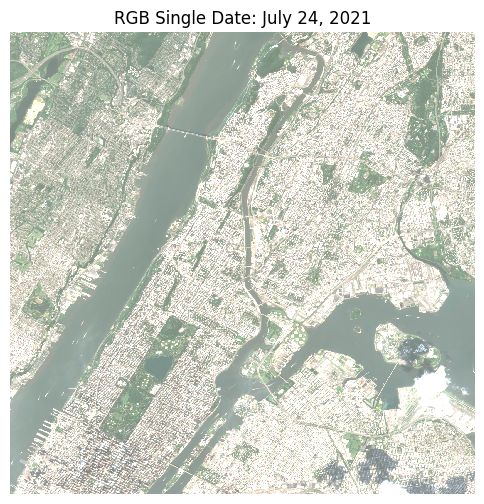

In [28]:
# Plot an RGB image for a single date
fig, ax = plt.subplots(figsize=(6,6))
plot_data.isel(time=7).plot.imshow(robust=True, ax=ax, vmin=0, vmax=2500)
ax.set_title("RGB Single Date: July 24, 2021")
ax.axis('off')
plt.show()

### Median composite

Using normal xarray operations, we can [compute the median](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.median.html) over the time dimension. Under the assumption that clouds are not common (<30% per scene) and in random locations, the composite shouldn't contain (many) clouds, since they shouldn't be the median pixel value at that point over many images. 

In [29]:
median = data.median(dim="time").compute()

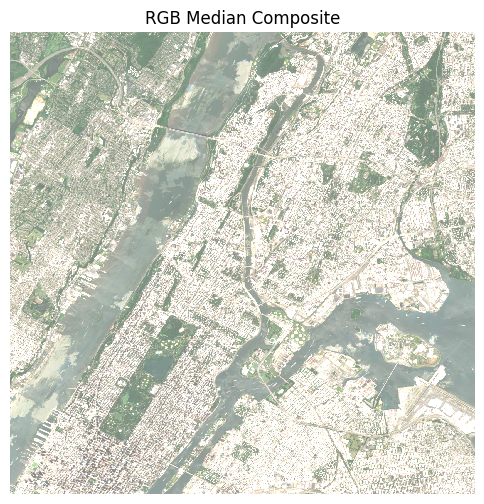

In [30]:
# Plot an RGB image for the median composite or mosaic
# Notice how this new image is void of clouds due to statistical filtering
fig, ax = plt.subplots(figsize=(6,6))
median[["B04", "B03", "B02"]].to_array().plot.imshow(robust=True, ax=ax, vmin=0, vmax=2500)
ax.set_title("RGB Median Composite")
ax.axis('off')
plt.show()

The <b>Normalized Difference Vegetation Index (NDVI)</b> is used to measure the "greenness" of vegetation and has a range of 0.0 to 1.0. Low values (0.0 to 0.25) reflect a lack of vegetation (bare soil, urban, water), middle values (0.25 to 0.6) reflect grasslands or croplands in their growing state, and high values (0.6 to 1.0) reflect dense vegetation such as trees or croplands at their peak vegetation state. Such information can be relevant to modeling urban heating as the proximity to vegetation or "green space" can mitigate urban heating. The equation uses two spectral bands where: <b>NDVI = (NIR-Red) / (NIR+Red).

In [31]:
# Calculate NDVI for the median mosaic
ndvi_median = (median.B08-median.B04)/(median.B08+median.B04)

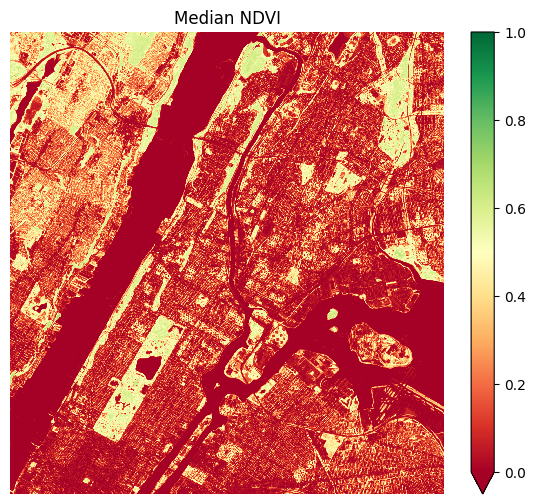

In [32]:
fig, ax = plt.subplots(figsize=(7,6))
ndvi_median.plot.imshow(vmin=0.0, vmax=1.0, cmap="RdYlGn")
plt.title("Median NDVI")
plt.axis('off')
plt.show()

The <b>Normalized Difference Buildup Index (NDBI)</b> is a ratio-based index that uses the Near Infra-red (NIR) and shortwave-infrared (SWIR) band (1.6 um, Band-11) to highlight built-up areas or areas of urbanization. Low values (below zero) reflect a lack of urbanization and are typical of water or vegetgation. High values (above zero) reflect urbanization with the highest densities where the colors are dark red. Such information can be relevant to modeling urban heating as urban density and increase urban heating. The equation uses two spectral bands where: <b>NDBI = (SWIR-NIR) / (SWIR+NIR).

In [33]:
# Calculate NDBI for the median mosaic
ndbi_median = (median.B11-median.B08)/(median.B11+median.B08)

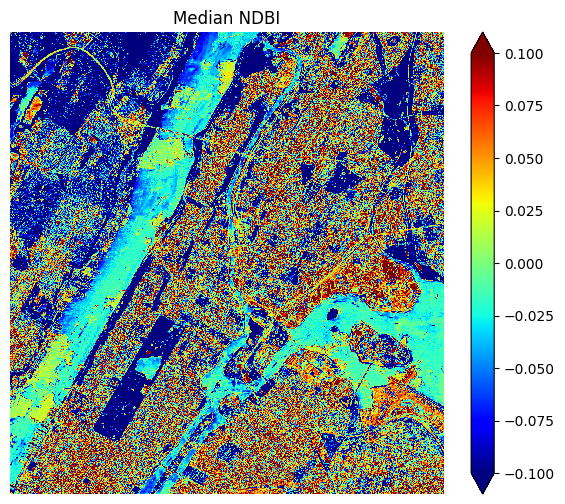

In [34]:
fig, ax = plt.subplots(figsize=(7,6))
ndbi_median.plot.imshow(vmin=-0.1, vmax=0.1, cmap="jet")
plt.title("Median NDBI")
plt.axis('off')
plt.show()

The <b>Normalized Difference Water Index (NDWI)</b> is a ratio-based index that uses the Green and Near Infra-Red (NIR) band to highlight areas with surface water. The scale below is set up to highlight areas of water (above zero) in BLUE and areas of non-water (below zero) in RED. Such information can be relevant to modeling urban heating as the proximity to water can mitigate urban heating. The equation uses two spectral bands where: <b>NDWI = (GREEN-NIR) / (GREEN+NIR).

In [35]:
# Calculate NDWI for the median mosaic
ndwi_median = (median.B03-median.B08)/(median.B03+median.B08)

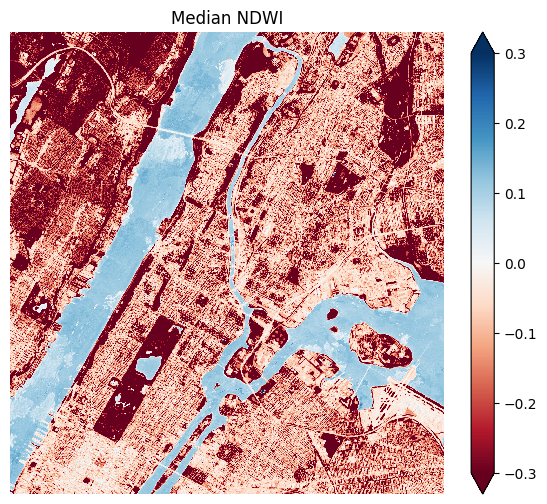

In [36]:
fig, ax = plt.subplots(figsize=(7,6))
ndwi_median.plot.imshow(vmin=-0.3, vmax=0.3, cmap="RdBu")
plt.title("Median NDWI")
plt.axis('off')
plt.show()

### Save the output data in a GeoTIFF file
We have selected a single date (July 24, 2021) to create a GeoTIFF output product. This date is the same as the ground temperature data collection date. Though this image contains some clouds, it will be used as the baseline for the benchmark notebook. Participants in the data challenge may desire to use other single scenes with less cloud cover or create a median mosaic that statistically filters the clouds over a time series stack of data (see the median dataset above).
<br><br>The output product below only contains 4 selected bands that are used in the benchmark notebook. Participants may choose to include all of the bands for their models to investigate how different bands and derived spectral indices change their model results. 

In [37]:
filename = "S2_nomedian_update_sample.tiff"

In [38]:
display(data)
display(median)

<xarray.Dataset> Size: 479MB
Dimensions:      (latitude: 1448, longitude: 1671, time: 9)
Coordinates:
  * latitude     (latitude) float64 12kB 40.88 40.88 40.88 ... 40.75 40.75 40.75
  * longitude    (longitude) float64 13kB -74.01 -74.01 -74.01 ... -73.86 -73.86
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 72B 2024-06-15T15:39:41.024000 ... 202...
Data variables:
    B01          (time, latitude, longitude) uint16 44MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B02          (time, latitude, longitude) uint16 44MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B03          (time, latitude, longitude) uint16 44MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B04          (time, latitude, longitude) uint16 44MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B05          (time, latitude, longitude) uint16 44MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B06          (time, latitude, longitude) uint16 44MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B07          (time, latitude, longitude) uint16 44MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B08          (time, latitude, longitude) uint16 44MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B8A          (time, latitude, longitude) uint16 44MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B11          (time, latitude, longitude) uint16 44MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B12          (time, latitude, longitude) uint16 44MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>

<xarray.Dataset> Size: 213MB
Dimensions:      (latitude: 1448, longitude: 1671)
Coordinates:
  * latitude     (latitude) float64 12kB 40.88 40.88 40.88 ... 40.75 40.75 40.75
  * longitude    (longitude) float64 13kB -74.01 -74.01 -74.01 ... -73.86 -73.86
    spatial_ref  int32 4B 4326
Data variables:
    B01          (latitude, longitude) float64 19MB 1.729e+03 ... 2.201e+03
    B02          (latitude, longitude) float64 19MB 1.592e+03 ... 2.25e+03
    B03          (latitude, longitude) float64 19MB 1.808e+03 ... 2.286e+03
    B04          (latitude, longitude) float64 19MB 1.708e+03 ... 2.454e+03
    B05          (latitude, longitude) float64 19MB 1.941e+03 ... 2.771e+03
    B06          (latitude, longitude) float64 19MB 2.962e+03 ... 2.748e+03
    B07          (latitude, longitude) float64 19MB 3.292e+03 ... 2.802e+03
    B08          (latitude, longitude) float64 19MB 2.808e+03 ... 2.588e+03
    B8A          (latitude, longitude) float64 19MB 3.464e+03 ... 2.8e+03
    B11          (latitude, longitude) float64 19MB 2.605e+03 ... 3.198e+03
    B12          (latitude, longitude) float64 19MB 2.042e+03 ... 2.998e+03

In [39]:
# We will pick a single time slice from the time series (time=7) 
# This time slice is the date of July 24, 2021
data_slice = data.isel(time=7)

# median_slice=median.isel(time=7)

In [40]:
data_slice

<xarray.Dataset> Size: 53MB
Dimensions:      (latitude: 1448, longitude: 1671)
Coordinates:
  * latitude     (latitude) float64 12kB 40.88 40.88 40.88 ... 40.75 40.75 40.75
  * longitude    (longitude) float64 13kB -74.01 -74.01 -74.01 ... -73.86 -73.86
    spatial_ref  int32 4B 4326
    time         datetime64[ns] 8B 2024-08-24T15:39:31.024000
Data variables:
    B01          (latitude, longitude) uint16 5MB dask.array<chunksize=(1448, 1671), meta=np.ndarray>
    B02          (latitude, longitude) uint16 5MB dask.array<chunksize=(1448, 1671), meta=np.ndarray>
    B03          (latitude, longitude) uint16 5MB dask.array<chunksize=(1448, 1671), meta=np.ndarray>
    B04          (latitude, longitude) uint16 5MB dask.array<chunksize=(1448, 1671), meta=np.ndarray>
    B05          (latitude, longitude) uint16 5MB dask.array<chunksize=(1448, 1671), meta=np.ndarray>
    B06          (latitude, longitude) uint16 5MB dask.array<chunksize=(1448, 1671), meta=np.ndarray>
    B07          (latitude, longitude) uint16 5MB dask.array<chunksize=(1448, 1671), meta=np.ndarray>
    B08          (latitude, longitude) uint16 5MB dask.array<chunksize=(1448, 1671), meta=np.ndarray>
    B8A          (latitude, longitude) uint16 5MB dask.array<chunksize=(1448, 1671), meta=np.ndarray>
    B11          (latitude, longitude) uint16 5MB dask.array<chunksize=(1448, 1671), meta=np.ndarray>
    B12          (latitude, longitude) uint16 5MB dask.array<chunksize=(1448, 1671), meta=np.ndarray>

In [41]:
# Calculate the dimensions of the file
height = median.dims["latitude"]
width = median.dims["longitude"]
# height = data_slice.dims["latitude"]
# width = data_slice.dims["longitude"]

In [42]:
# Define the Coordinate Reference System (CRS) to be common Lat-Lon coordinates
# Define the tranformation using our bounding box so the Lat-Lon information is written to the GeoTIFF
gt = rasterio.transform.from_bounds(lower_left[1],lower_left[0],upper_right[1],upper_right[0],width,height)
median.rio.write_crs("epsg:4326", inplace=True)
median.rio.write_transform(transform=gt, inplace=True);

In [43]:
["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12"]

['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12']

In [44]:
# Create the GeoTIFF output file using the defined parameters 
with rasterio.open(filename,'w',driver='GTiff',width=width,height=height,
                   crs='epsg:4326',transform=gt,count=11,compress='lzw',dtype='float64') as dst:
    dst.write(median.B01,1)
    dst.write(median.B02,2)
    dst.write(median.B03,3) 
    dst.write(median.B04,4)
    dst.write(median.B05,5)
    dst.write(median.B06,6)
    dst.write(median.B07,7)
    dst.write(median.B08,8)
    dst.write(median.B8A,9)
    dst.write(median.B11,10)
    dst.write(median.B12,11)
    dst.close()

In [47]:
# Show the location and size of the new output file
!dir

 Volume in drive C has no label.
 Volume Serial Number is 4067-E510

 Directory of C:\Users\USER\Desktop\Machine  Learning\Cooling Urban Heats Islands\Dataset

03/15/2025  07:38 AM    <DIR>          .
03/15/2025  07:38 AM    <DIR>          ..
02/05/2025  03:56 PM    <DIR>          .ipynb_checkpoints
02/05/2025  03:29 PM         1,954,272 2025 EY Open Science AI Data Challenge Participant Guidance.pdf
02/07/2025  11:25 AM         8,570,289 Additional_bands.tiff
02/27/2025  12:07 PM         8,636,781 Additional_median_bands.tiff
03/15/2025  04:50 AM         8,619,929 Additional_median_update_bands.tiff
02/05/2025  03:29 PM         9,229,354 Building_Footprint.kml
03/15/2025  07:30 AM         2,955,717 Landsat_LST.ipynb
02/06/2025  11:18 PM         2,095,342 Landsat_LST.tiff
02/27/2025  12:07 PM         2,131,528 Landsat_median_LST.tiff
03/15/2025  04:50 AM         2,132,625 Landsat_median_update_LST.tiff
02/16/2025  02:56 PM         2,445,873 NY_Mesonet_Weather.xlsx
02/13/2025  12:17 AM 